# Batch PDF processing (Processamento em lote de PDFs)

Dan Keemahill ([@dankeemahill](https://twitter.com/dankeemahill))

https://github.com/dankeemahill/nicar20-batch-pdf-processing

## Welcome!

Nesta sessão de uma hora, percorreremos o código ** Python** que extrai dados de **nove PDFs**.

### E se eu precisar analisar lotes maiores de PDFs, como 1.000 ou 10.000 ou 1.000.000 ou ...?

- Confira [como o ICIJ extraiu 715.000 registros](https://www.icij.org/investigations/luanda-leaks/how-we-mined-more-than-715000-luanda-leaks-records/) com sua ferramenta de código aberto [Datashare](https://www.icij.org/blog/2019/11/what-is-datashare-frequently-asked-questions-about-our-document-analysis-software/)

- Confira como Miguel Barbosa fez em 2018 [apresentação](https://docs.google.com/presentation/d/12ShGfr3HhSXdLwK5R1pr1J5cvjLXuEmaXGxErG3gShg/preview)

- Veja Jacob Fenton [sessão](https://ireapps.github.io/nicar-2020-schedule#20200308_pdf_3_batch_pdf_processing_repeat_2478) no Domingo

### Os conceitos se aplicam, independentemente de quantos PDFs você tenha

- Conheça os tipos de PDFs
- Tentativa e erro
- Dividir e conquistar
- Confira os fatos
- [Colabore](https://source.opennews.org/articles/news-nerds-against-pdfs/)


### O desafio

O ICE (imigração e fiscalização aduaneira) tem uma [página](https://www.ice.gov/facility-inspections) de inspeções em instalações de detenção, com PDF. A maioria das inspeções envolve uma "carta de apresentação" que lista os padrões de violações e seus componentes e um "formulário de revisão resumida" que tabula incidentes e fornece narrativas.

O USA TODAY Network fez uma [investigação](https://www.usatoday.com/in-depth/news/nation/2019/12/19/ice-detention-private-prisons-expands-under-trump-administration/4393366002/) de prisões particulares que detêm imigrantes, queríamos então contar violações desses relatórios.

Neste notebook, demonstrarei a análise de queixas arquivadas em formulários de resumo com a biblioteca [pdfplumber](https://github.com/jsvine/pdfplumber).

### Por que [pdfplumber](https://github.com/jsvine/pdfplumber)?

Existem muitas ferramentas de código aberto que podem trabalhar com PDFs! O [2019 Q4 IRE Journal](https://www.ire.org/wp-content/uploads/2019/12/IREJournal_Q4_2019.pdf) tem uma lista útil de ferramentas

Eu me virei com o pdfplumber por alguns motivos: estou familiarizado com Python, tinha experiência anterior com pdfplumber e porque o pdfplumber foi construído pelo jornalista Jeremy Singer-Vine e [contribuições](https://github.com/jsvine/pdfplumber#acknowledgments--contributors).

Mais importante, eu estava confiante que o pdfplumber poderia trabalhar para a tarefa porque os PDFs eram do "nativo" [tipo](https://docs.google.com/presentation/d/12ShGfr3HhSXdLwK5R1pr1J5cvjLXuEmaXGxErG3gShg/preview?slide=id.g1ebfd012eb_0_40).

### Conhecendo os PDFs

In [ ]:
# Se necessário instale antes (só uma vez)
# E o mesmo para todas as bibliotecas necessárias
!pip3 install pdfplumber
!pip3 install pandas

In [ ]:
# Para ver PDFs na página no Windows também deve instalar o ImageMagick
# http://docs.wand-py.org/en/latest/guide/install.html#install-imagemagick-on-windows

In [1]:
# examina o diretório
# use ls em linux ou ubuntu
 !ls pdf/
# use dir em windows
# !dir pdf

allenParishDetFac_SIS_02-14-2019.pdf
catahoulaLA_SIS_08-22-2019.pdf
jenaLaSalle_SIS_09-26-2019.pdf
LAWINCI_SIS_10-10-2019.pdf
natchitochesDcLA_SIS_07-03-2019.pdf
RiverCorrectionalCenter_SIS_12-06-2018.pdf
RVRCCLA_SIS_10-24-2019.pdf
RWCCMLA_SIS_10-03-2019.pdf


In [2]:
import pdfplumber

In [3]:
pdf = pdfplumber.open(
    'pdf/jenaLaSalle_SIS_09-26-2019.pdf'
)

In [4]:
pdf.pages

In [5]:
# Quantas páginas esse PDF possui?

len(pdf.pages)

9

In [6]:
# obtenha a primeira página

page = pdf.pages[0]

In [ ]:
'''
No Linux talvez o ImageMagick necessite ser habilitado para leitura.  Uma correção de segurança do pacote subjacente (consulte https://bugs.launchpad.net/ubuntu/+source/imagemagick/+bug/1796563)

Eu o corrigi editando o arquivo /etc/ImageMagick-6/policy.xml e alterei os direitos da linha pdf para "read", lendo aqui https://stackoverflow.com/questions/52699608/wand-policy-error-error-constitute-c-readimage-412:

<policy domain="coder" rights="read" pattern="PDF" />

E depois reiniciar o notebook
'''

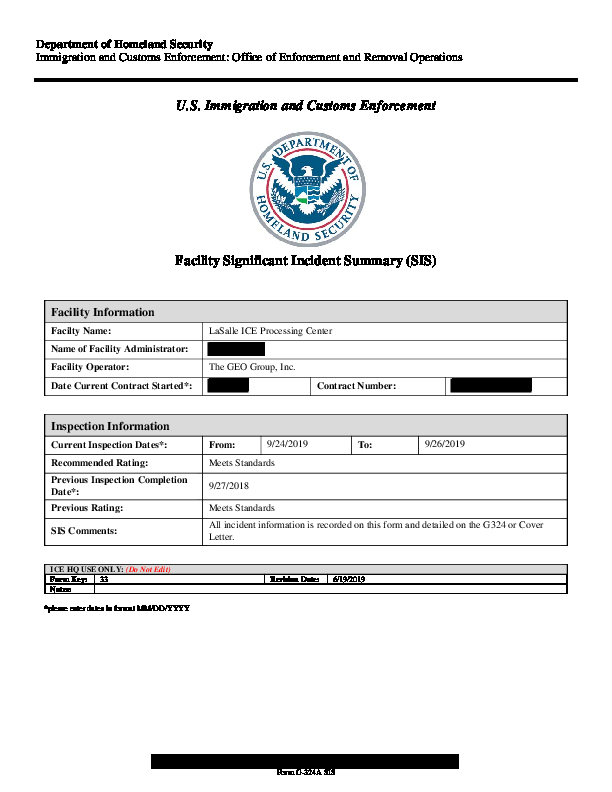

In [7]:
# como é a primeira página?

page.to_image()

### Onde estão as queixas neste PDF?

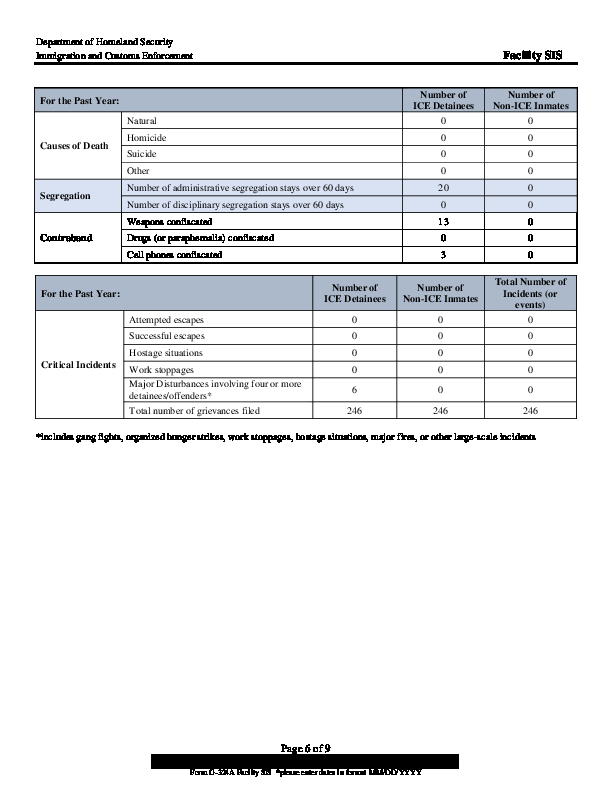

In [8]:
page = pdf.pages[5]
page.to_image()

### Encontre as queixas em um PDF diferente

In [9]:
pdf = pdfplumber.open(
    'pdf/allenParishDetFac_SIS_02-14-2019.pdf'
)

In [10]:
page = pdf.pages[5]

IndexError: list index out of range

_Oh puxa! _ O que aconteceu?

In [11]:
len(pdf.pages)

4

### Coletar metadados sobre nossos PDFs

Acabamos de aprender que diferentes PDFs têm diferentes números de páginas. Essa é uma ótima chance de aprender mais sobre nossos documentos criando metadados sobre eles.

Quantas páginas possui cada PDF?

In [14]:
# importar uma biblioteca python que nos ajuda a encontrar lotes de arquivos

from glob import glob

In [15]:
glob('pdf/*')

['pdf/RVRCCLA_SIS_10-24-2019.pdf',
 'pdf/natchitochesDcLA_SIS_07-03-2019.pdf',
 'pdf/catahoulaLA_SIS_08-22-2019.pdf',
 'pdf/jenaLaSalle_SIS_09-26-2019.pdf',
 'pdf/allenParishDetFac_SIS_02-14-2019.pdf',
 'pdf/RWCCMLA_SIS_10-03-2019.pdf',
 'pdf/RiverCorrectionalCenter_SIS_12-06-2018.pdf',
 'pdf/LAWINCI_SIS_10-10-2019.pdf']

In [16]:
# exibir cada PDF e o número de páginas que ele possui

for file_name in glob('pdf/*'):
    pdf = pdfplumber.open(file_name)
    print(
        file_name,
        len(pdf.pages)
    )

pdf/RVRCCLA_SIS_10-24-2019.pdf 9
pdf/natchitochesDcLA_SIS_07-03-2019.pdf 4
pdf/catahoulaLA_SIS_08-22-2019.pdf 4
pdf/jenaLaSalle_SIS_09-26-2019.pdf 9
pdf/allenParishDetFac_SIS_02-14-2019.pdf 4
pdf/RWCCMLA_SIS_10-03-2019.pdf 9
pdf/RiverCorrectionalCenter_SIS_12-06-2018.pdf 4
pdf/LAWINCI_SIS_10-10-2019.pdf 9


In [18]:
# importar uma biblioteca python que nos ajude a trabalhar com dados

import pandas as pd

In [19]:
# faça uma lista de dicionários que contêm metadados

payload = []

for file_name in glob('pdf/*'):
    pdf = pdfplumber.open(file_name)
    payload.append({
        'file_name': file_name,
        'pages': len(pdf.pages)
    })

payload

[{'file_name': 'pdf/RVRCCLA_SIS_10-24-2019.pdf', 'pages': 9},
 {'file_name': 'pdf/natchitochesDcLA_SIS_07-03-2019.pdf', 'pages': 4},
 {'file_name': 'pdf/catahoulaLA_SIS_08-22-2019.pdf', 'pages': 4},
 {'file_name': 'pdf/jenaLaSalle_SIS_09-26-2019.pdf', 'pages': 9},
 {'file_name': 'pdf/allenParishDetFac_SIS_02-14-2019.pdf', 'pages': 4},
 {'file_name': 'pdf/RWCCMLA_SIS_10-03-2019.pdf', 'pages': 9},
 {'file_name': 'pdf/RiverCorrectionalCenter_SIS_12-06-2018.pdf', 'pages': 4},
 {'file_name': 'pdf/LAWINCI_SIS_10-10-2019.pdf', 'pages': 9}]

In [20]:
# crie um dataframe dos metadados e exiba o quadro de dados

pdf_meta = pd.DataFrame(
    payload
)

pdf_meta

,file_name,pages
0,pdf/RVRCCLA_SIS_10-24-2019.pdf,9
1,pdf/natchitochesDcLA_SIS_07-03-2019.pdf,4
2,pdf/catahoulaLA_SIS_08-22-2019.pdf,4
3,pdf/jenaLaSalle_SIS_09-26-2019.pdf,9
4,pdf/allenParishDetFac_SIS_02-14-2019.pdf,4
5,pdf/RWCCMLA_SIS_10-03-2019.pdf,9
6,pdf/RiverCorrectionalCenter_SIS_12-06-2018.pdf,4
7,pdf/LAWINCI_SIS_10-10-2019.pdf,9


Sabemos que esses registros têm diferentes comprimentos de página, mas onde estão as tabelas de queixas em cada PDF?

### Encontre padrões no texto com expressões regulares

Vamos praticar!

In [21]:
import re

Queremos encontrar páginas que contenham "Grievances:" `OR` "grievances"

In [22]:
pattern_grievance_table = r'Grievances:|grievances'

"Mesmo aprender apenas a escrever um loop simples é muito útil para converter PDFs." - Todd Wallack, [NICAR 2017](https://www.ire.org/resource-center/audio/1223/)

In [23]:
payload = []

# passa por todos os arquivos PDF no diretório

for file_name in glob('pdf/*'):
    pdf = pdfplumber.open(file_name)
    
    # volta sobre cada página no PDF aberto
    
    for page_index, page in enumerate(pdf.pages):

        if re.search(
                pattern_grievance_table,
                page.extract_text()
            ):
            
            # adicionar metadados à lista se o padrão de queixas for encontrado

            payload.append({
                'file_name': file_name,
                'table_page': page_index
            })
            
            
pdf_grievance_pages = pd.DataFrame(payload)

In [24]:
pdf_meta = pdf_grievance_pages.merge(
    pdf_meta,
    on='file_name'
)

pdf_meta

,file_name,table_page,pages
0,pdf/RVRCCLA_SIS_10-24-2019.pdf,5,9
1,pdf/natchitochesDcLA_SIS_07-03-2019.pdf,1,4
2,pdf/catahoulaLA_SIS_08-22-2019.pdf,1,4
3,pdf/jenaLaSalle_SIS_09-26-2019.pdf,5,9
4,pdf/allenParishDetFac_SIS_02-14-2019.pdf,1,4
5,pdf/RWCCMLA_SIS_10-03-2019.pdf,5,9
6,pdf/RiverCorrectionalCenter_SIS_12-06-2018.pdf,1,4
7,pdf/LAWINCI_SIS_10-10-2019.pdf,5,9


Agora sabemos onde estão os dados de queixas em cada documento. Hora de analisar!

### Analisar um único PDF

In [25]:
# obter metadados para um PDF

pdf_row = pdf_meta.loc[
    lambda x: x['file_name'] == 'pdf/allenParishDetFac_SIS_02-14-2019.pdf'
].iloc[0]

pdf_row

file_name     pdf/allenParishDetFac_SIS_02-14-2019.pdf
table_page                                           1
pages                                                4
Name: 4, dtype: object

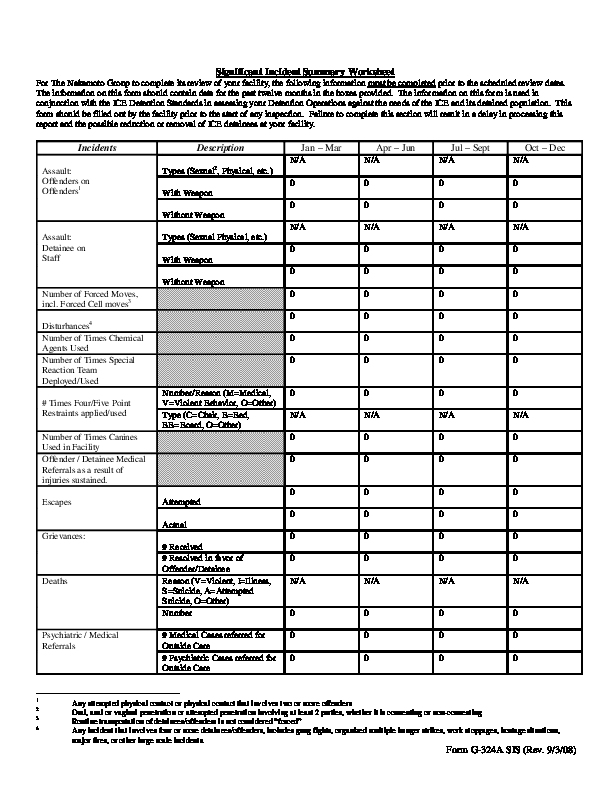

In [26]:
pdf = pdfplumber.open(pdf_row['file_name'])

# use nossos metadados para abrir a página com os dados de reclamações e visualizá-los

page = pdf.pages[
    pdf_row['table_page']
]

page.to_image()

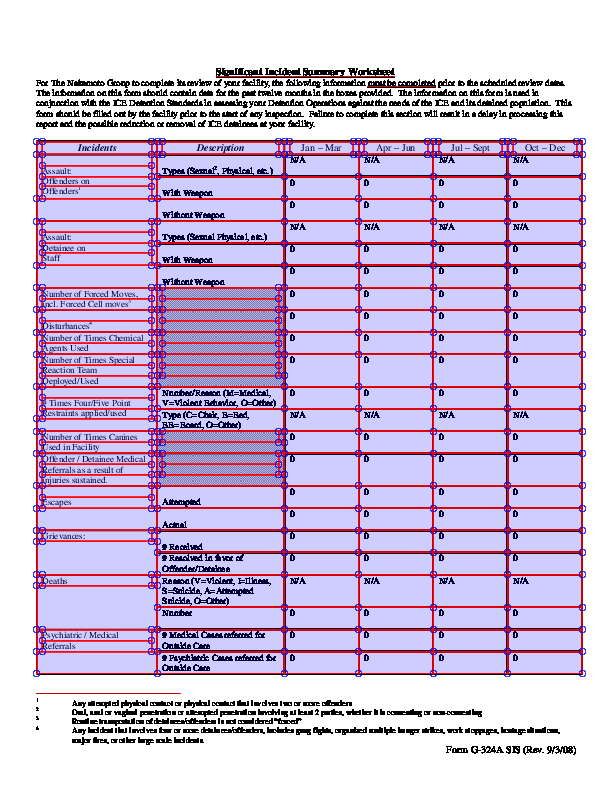

In [27]:
# use o pdfplumber tablefinder!

page.to_image().debug_tablefinder()

O depurador parece confuso porque o PDF possui linhas inconsistentes.

Poderíamos analisar a página inteira e limpá-la como uma segunda etapa, mas também podemos ampliar uma área menor e extraí-la com mais precisão.

Nesse caso, queremos apenas a linha "Greivances Received". Podemos "cortar" a página usando coordenadas de pixel.

pdfplumber pode cortar pdfs com caixas delimitadoras, que são `"4-tuple with the values (x0, top, x1, bottom)"`

Outra maneira de lembrar: `(left, top, right, bottom)`

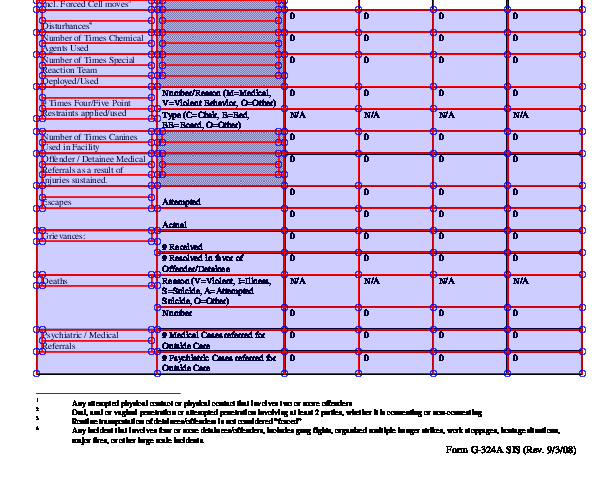

In [28]:
crop_coordinates = (0, 300, page.width, page.height)

page_cropped = page.crop(crop_coordinates)

page_cropped.to_image().debug_tablefinder()

Obter as coordenadas exatamente corretas pode ser complicado.

Abri um PDF no Adobe Illustrator e usei sua interface para encontrar coordenadas, mas também podemos usar o pdfplumber para encontrar coordenadas.

pdfplumber fornece as coordenadas das `palavras`, podemos usá-las para determinar onde devemos cortar.

In [29]:
page.extract_words()

[{'x0': Decimal('216.000'),
  'x1': Decimal('262.329'),
  'top': Decimal('64.476'),
  'bottom': Decimal('78.426'),
  'text': 'Significant'},
 {'x0': Decimal('264.973'),
  'x1': Decimal('300.498'),
  'top': Decimal('64.476'),
  'bottom': Decimal('78.426'),
  'text': 'Incident'},
 {'x0': Decimal('302.902'),
  'x1': Decimal('344.905'),
  'top': Decimal('64.476'),
  'bottom': Decimal('78.426'),
  'text': 'Summary'},
 {'x0': Decimal('347.546'),
  'x1': Decimal('394.343'),
  'top': Decimal('64.476'),
  'bottom': Decimal('78.426'),
  'text': 'Worksheet'},
 {'x0': Decimal('36.000'),
  'x1': Decimal('48.400'),
  'top': Decimal('76.195'),
  'bottom': Decimal('88.480'),
  'text': 'For'},
 {'x0': Decimal('50.884'),
  'x1': Decimal('65.013'),
  'top': Decimal('76.195'),
  'bottom': Decimal('88.480'),
  'text': 'The'},
 {'x0': Decimal('67.202'),
  'x1': Decimal('104.647'),
  'top': Decimal('76.195'),
  'bottom': Decimal('88.480'),
  'text': 'Nakamoto'},
 {'x0': Decimal('106.809'),
  'x1': Decimal('1

In [30]:
coordinate_grievances = list(filter(
    lambda x: x['text'] == 'Grievances:',
    page.extract_words()
))[0]

coordinate_grievances

{'x0': Decimal('42.240'),
 'x1': Decimal('85.576'),
 'top': Decimal('529.795'),
 'bottom': Decimal('542.080'),
 'text': 'Grievances:'}

Tentativa e erro!

In [31]:
coordinate_left = coordinate_grievances['x1'] + 100
coordinate_right = page.width
coordinate_top = coordinate_grievances['top'] - 5
coordinate_bottom = coordinate_grievances['top'] + 30

In [32]:
crop_coordinates = (coordinate_left, coordinate_top, coordinate_right, coordinate_bottom)

crop_coordinates

(Decimal('185.576'),
 Decimal('524.795'),
 Decimal('612.000'),
 Decimal('559.795'))

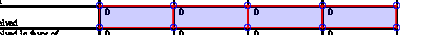

In [33]:
page.within_bbox(
    crop_coordinates
).to_image().debug_tablefinder()

Muito melhor, vamos pegar a tabela!

In [34]:
extracted_table = page.within_bbox(
    crop_coordinates
).extract_table()

extracted_table

[['0', '0', '0', '0']]

Os dados são apenas uma linha, mas vamos criar um DataFrame do pandas.

In [35]:
pd.DataFrame(
    extracted_table,
    columns=['q1', 'q2', 'q3', 'q4']
).astype(int).assign(
    total = lambda x: x.sum(axis=1),
    file=file_name
)

,q1,q2,q3,q4,total,file
0,0,0,0,0,0,pdf/LAWINCI_SIS_10-10-2019.pdf


Agora vamos extrair queixas de um PDF de nove páginas.

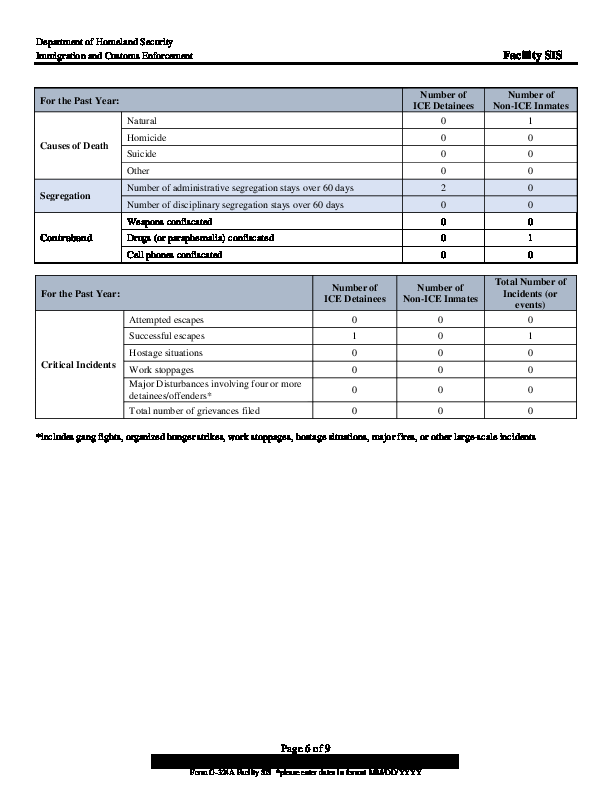

In [36]:
pdf_row = pdf_meta.loc[
    lambda x: x['pages'] == 9
].iloc[0]

pdf = pdfplumber.open(pdf_row['file_name'])

page = pdf.pages[
    pdf_row['table_page']
]

page.to_image()

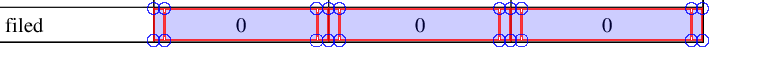

In [37]:
coordinate_grievances = list(filter(
    lambda x: x['text'] == 'grievances',
    page.extract_words()
))[0]

# Encontrei esses valores exatos após tentativa e erro!
coordinate_left = coordinate_grievances['x1']
coordinate_right = page.width
coordinate_top = coordinate_grievances['top'] - 5
coordinate_bottom = coordinate_grievances['top'] + 30

crop_coordinates = (coordinate_left, coordinate_top, coordinate_right, coordinate_bottom)

page.within_bbox(
    crop_coordinates
).to_image(resolution=150).debug_tablefinder()

O corte parece próximo, mas observe que o tablefinder está adicionando mais linhas do que precisamos. Podemos usar um dos muitos pdfplumber [table settings](https://github.com/jsvine/pdfplumber#table-extraction-settings) para afinar a tabla. Nesse caso, achei que a configuração `snap_tolerance` ajudou nas várias linhas.

In [38]:
pd.DataFrame(
    page.within_bbox(
        crop_coordinates
    ).extract_table({
        'snap_tolerance': 8
    }),
    columns = [
        'ice',
        'non_ice',
        'total'
    ]
).astype(int).assign(
    file=file_name
)

,ice,non_ice,total,file
0,0,0,0,pdf/LAWINCI_SIS_10-10-2019.pdf


Extraímos dados de um PDF de 4 páginas e de 9 páginas e podemos aplicar essas técnicas a todo o lote.

"Mesmo aprender apenas a escrever um loop simples é muito útil para converter PDFs."- Todd Wallack, [NICAR 2017](https://www.ire.org/resource-center/audio/1223/)

In [39]:
def process_row(row):
    pdf = pdfplumber.open(row['file_name'])
    page = pdf.pages[row['table_page']]
    page_count = row['pages']
    
    coordinate_grievances = list(filter(
        lambda x: re.search(
            pattern_grievance_table, x['text']
        ),
        page.extract_words()
    ))[0]
    
    coordinate_left = coordinate_grievances['x1']
    coordinate_right = page.width
    
    if row['pages'] == 9:
        coordinate_top = coordinate_grievances['top'] - 5
        coordinate_bottom = coordinate_grievances['top'] + 30
        
    else:
        coordinate_left = coordinate_left + 100
        coordinate_top = coordinate_grievances['top'] - 5
        coordinate_bottom = coordinate_grievances['top'] + 30

    crop_coordinates = (coordinate_left, coordinate_top, coordinate_right, coordinate_bottom)
        
    page = page.within_bbox(crop_coordinates)
    
    if page_count == 9:
        return pd.DataFrame(
            page.extract_table({
                'snap_tolerance': 8
            }),
            columns = [
                'ice',
                'non_ice',
                'total'
            ]
        ).astype(int).assign(
            total=lambda x: x['ice'] + x['non_ice'],
            file=row['file_name']
        )

    else:
        return pd.DataFrame(
            page.extract_table(),
            columns=[
                'q1',
                'q2',
                'q3',
                'q4'
            ]
        ).astype(int).assign(
            total=lambda x: x.sum(axis=1),
            file=row['file_name']
        )


Nossa função está pronta, vamos executá-la em todos os PDFs!

In [40]:
payload = []

for index, row in pdf_meta.iterrows():
    payload.append(process_row(row))

ValueError: invalid literal for int() with base 10: 'N/A'

De onde vem "N/A"?

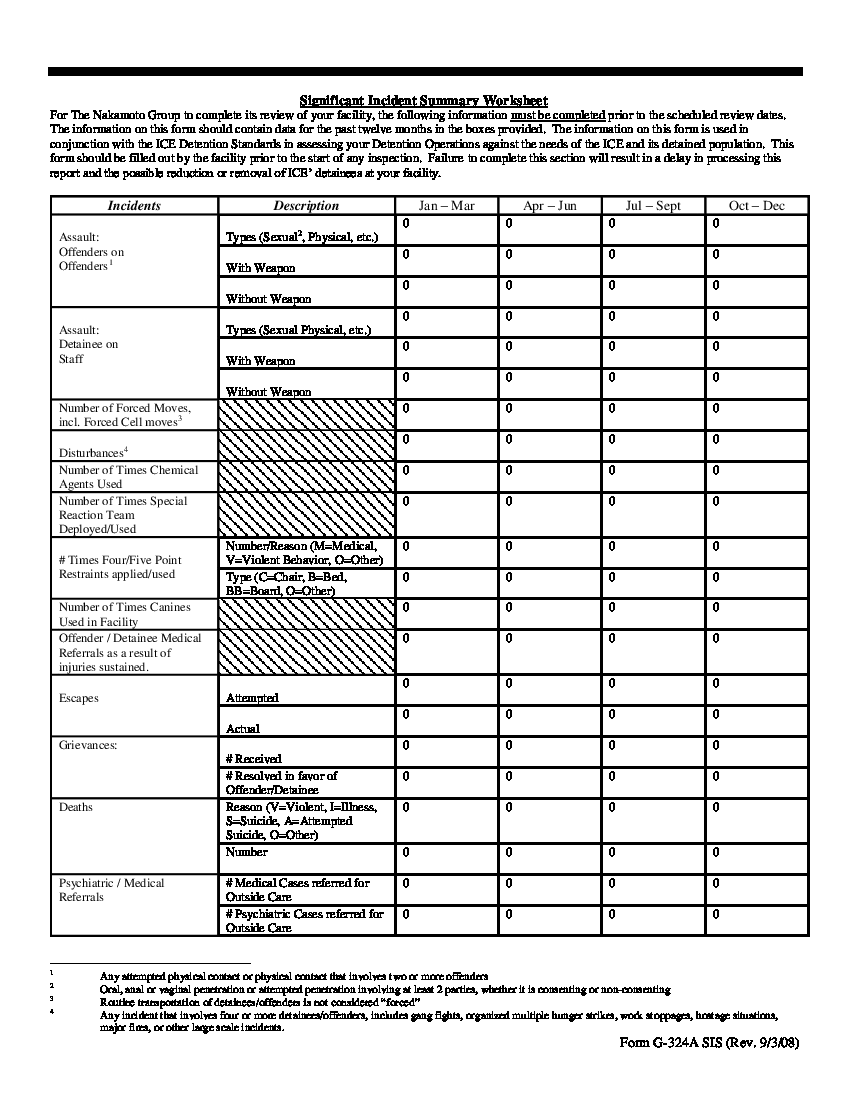

In [41]:
pdfplumber.open(
    pdf_meta.iloc[1]['file_name']
).pages[
    pdf_meta.iloc[1]['table_page']
].to_image(resolution=100)

Nossa função precisa de um ajuste para converter `N/A` para `0` para que possamos somar queixas.

In [42]:
def process_row(row):
    pdf = pdfplumber.open(row['file_name'])
    page = pdf.pages[row['table_page']]
    page_count = row['pages']
    
    coordinate_grievances = list(filter(
        lambda x: re.search(
            pattern_grievance_table, x['text']
        ),
        page.extract_words()
    ))[0]
    
    coordinate_left = coordinate_grievances['x1']
    coordinate_right = page.width
    
    if row['pages'] == 9:
        coordinate_top = coordinate_grievances['top'] - 5
        coordinate_bottom = coordinate_grievances['top'] + 30
        
    else:
        coordinate_left = coordinate_left + 100
        coordinate_top = coordinate_grievances['top'] - 5
        coordinate_bottom = coordinate_grievances['top'] + 30

    crop_coordinates = (coordinate_left, coordinate_top, coordinate_right, coordinate_bottom)
        
        
    page = page.within_bbox(crop_coordinates)
    
    if page_count == 9:
        return pd.DataFrame(
            page.extract_table({
                'snap_tolerance': 8
            }),
            columns = [
                'ice',
                'non_ice',
                'total'
            ]
        ).astype(int).assign(
            total=lambda x: x['ice'] + x['non_ice'],
            file=row['file_name']
        )

    else:
        return pd.DataFrame(
            page.extract_table(),
            columns=[
                'q1',
                'q2',
                'q3',
                'q4'
            ]
        ).replace('N/A', 0).astype(int).assign(
            total=lambda x: x.sum(axis=1),
            file=row['file_name']
        )

In [43]:
payload = []

for index, row in pdf_meta.iterrows():
    payload.append(process_row(row))

In [44]:
pd.concat(payload)[['file', 'total']]

,file,total
0,pdf/RVRCCLA_SIS_10-24-2019.pdf,0
0,pdf/natchitochesDcLA_SIS_07-03-2019.pdf,0
0,pdf/catahoulaLA_SIS_08-22-2019.pdf,1
0,pdf/jenaLaSalle_SIS_09-26-2019.pdf,492
0,pdf/allenParishDetFac_SIS_02-14-2019.pdf,0
0,pdf/RWCCMLA_SIS_10-03-2019.pdf,1
0,pdf/RiverCorrectionalCenter_SIS_12-06-2018.pdf,106
0,pdf/LAWINCI_SIS_10-10-2019.pdf,22


In [49]:
df_reclamacoes = pd.concat(payload)[['file', 'total']]

In [50]:
df_reclamacoes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 0 to 0
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   file    8 non-null      object
 1   total   8 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 192.0+ bytes


In [51]:
df_reclamacoes.reset_index().head()

,index,file,total
0,0,pdf/RVRCCLA_SIS_10-24-2019.pdf,0
1,0,pdf/natchitochesDcLA_SIS_07-03-2019.pdf,0
2,0,pdf/catahoulaLA_SIS_08-22-2019.pdf,1
3,0,pdf/jenaLaSalle_SIS_09-26-2019.pdf,492
4,0,pdf/allenParishDetFac_SIS_02-14-2019.pdf,0


In [52]:
df_reclamacoes.to_csv("reclamacoes_violacoes_contra_imigrantes_quantidade.csv", index=False)

## Veja todos os PDFs que analisamos!

Mas o processamento realmente envolveu muitas coisas. Nós:

- criamos dataframes de pandas sobre nossos dados
- escreveu loops `for`
- usou expressões regulares
- listas filtradas
- usou tentativa e erro para encontrar as coordenadas perfeitas em PDF
- erros depurados

pdfplumber ajudou a coletar dados dos relatórios, mas também usamos [Overview](https://blog.overviewdocs.com/) para pesquisar documentos de texto e OCR não legíveis por máquina que encontramos.